In [1]:
library(Seurat)
library(dplyr)
library(ggplot2)
inputdir <- "./load_files/"
outputdir <- "./report/"

Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
## Cell type average expression for visualization
avgFile <- "./load_files/Cor.DeepUpper.DEG.expr.avgs.rds"
if (!file.exists(avgFile)){
    exn <- readRDS(file = "../overview/load_files/ExN_data_08312022.rds")
    lexn <- subset(exn, subtype %in% c("ExN SOX5 SYT6", "ExN SOX5 NR4A2 GRID2", "ExN CUX2 ACTN2"))
    rm(exn)


    ## Get average expression by lobes
    lexn@meta.data$tmpcls <- paste0(lexn@meta.data$subtype, "|", lexn@meta.data$lobe)
    Idents(lexn) <- "tmpcls"
    avg <- log(AverageExpression(lexn, assay = "RNA")$RNA + 1)
    saveRDS(avg, file = avgFile)    
}
avgs <- readRDS(file = avgFile)
dim(avgs)
sum(is.na(avgs))

[1] 34619    15

[1] 0

In [3]:
## Get DEGs
upres <- readRDS(file = paste0("./load_files/", "DEGs_RES_bylobe_upper_E93.rds"))
deepres <- readRDS(file = paste0("./load_files/", "DEGs_RES_bylobe_deep_E54-64.rds"))

head(upres)
head(deepres)

,gene,p_val,avg_logFC,pct.1,pct.2,p_val_adj,ratio_fc,background,region,cluster,bgregion
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,PENK,1.235694e-146,1.2407010,0.591,0.063,4.277848e-142,8.232877,MSC|ExN CUX2 ACTN2,FC,ExN CUX2 ACTN2,MSC
2,CAV1,4.273235e-145,1.0933888,0.508,0.004,1.479351e-140,37.000000,MSC|ExN CUX2 ACTN2,FC,ExN CUX2 ACTN2,MSC
3,LMO4,2.770713e-141,0.8816497,0.979,0.806,9.591933e-137,1.212010,MSC|ExN CUX2 ACTN2,FC,ExN CUX2 ACTN2,MSC
4,NECAB1,7.062403e-135,1.0443865,0.712,0.208,2.444933e-130,3.311927,MSC|ExN CUX2 ACTN2,FC,ExN CUX2 ACTN2,MSC
5,CBLN2,2.119719e-115,1.0521982,0.570,0.109,7.338256e-111,4.873950,MSC|ExN CUX2 ACTN2,FC,ExN CUX2 ACTN2,MSC
6,VSTM2L,9.199058e-105,0.9608824,0.736,0.326,3.184622e-100,2.220238,MSC|ExN CUX2 ACTN2,FC,ExN CUX2 ACTN2,MSC


,gene,p_val,avg_logFC,pct.1,pct.2,p_val_adj,ratio_fc,background,region,cluster,bgregion
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,TUBA1A,1.002169e-113,0.3186994,1.000,1.000,3.469410e-109,1.000000,MSC|ExN SOX5 ID2,FC,ExN SOX5 ID2,MSC
2,STMN1,8.931353e-107,0.3113304,1.000,1.000,3.091945e-102,1.000000,MSC|ExN SOX5 ID2,FC,ExN SOX5 ID2,MSC
3,PCDH17,4.859944e-75,1.0133707,0.569,0.158,1.682464e-70,3.446429,MSC|ExN SOX5 ID2,FC,ExN SOX5 ID2,MSC
4,TUBB2B,1.136234e-69,0.2972559,1.000,0.998,3.933528e-65,1.001984,MSC|ExN SOX5 ID2,FC,ExN SOX5 ID2,MSC
5,RPRM,2.669926e-47,0.6353289,0.471,0.159,9.243016e-43,2.846154,MSC|ExN SOX5 ID2,FC,ExN SOX5 ID2,MSC
6,LOC699231,5.807858e-46,0.2464048,0.999,0.991,2.010623e-41,1.007992,MSC|ExN SOX5 ID2,FC,ExN SOX5 ID2,MSC


In [4]:
sel_cls <- c("ExN CUX2 ACTN2", "ExN SOX5 NR4A2 GRID2", "ExN SOX5 SYT6")
gene_use <- rbind(upres, deepres) %>%
            filter(cluster %in% sel_cls) %>%
            mutate(regionpair = paste0(region, "|", bgregion)) %>%
            subset(pct.1 >= 0.15 & ratio_fc >= 1.2 & avg_logFC >= 0.2) %>%
            group_by(cluster, regionpair) %>% 
            mutate(p_val_adj = p.adjust(p_val, method = "fdr")) %>%
            filter(p_val_adj <= 0.01) %>%
            ungroup() %>%
            .$gene %>% unique()
summary(gene_use)
sum(is.na(gene_use))

   Length     Class      Mode 
     2092 character character 

[1] 0

In [5]:
ptval <- 0.05 ## pseudo value for average expression fold change calculation
reg_ord <- c("FC", "MSC", "TC", "OC")
all_pairs <- combn(sel_cls, 2, simplify = FALSE)
all_pairs

[[1]]
[1] "ExN CUX2 ACTN2"       "ExN SOX5 NR4A2 GRID2"

[[2]]
[1] "ExN CUX2 ACTN2" "ExN SOX5 SYT6" 

[[3]]
[1] "ExN SOX5 NR4A2 GRID2" "ExN SOX5 SYT6"

[1] "FC"
[1] "MSC"
[1] "TC"
[1] "OC"
[1] 0
[1] 0
[1] "FC"
[1] "MSC"
[1] "TC"
[1] "OC"
[1] 0
[1] 0
[1] "FC"
[1] "MSC"
[1] "TC"
[1] "OC"
[1] 0
[1] 0


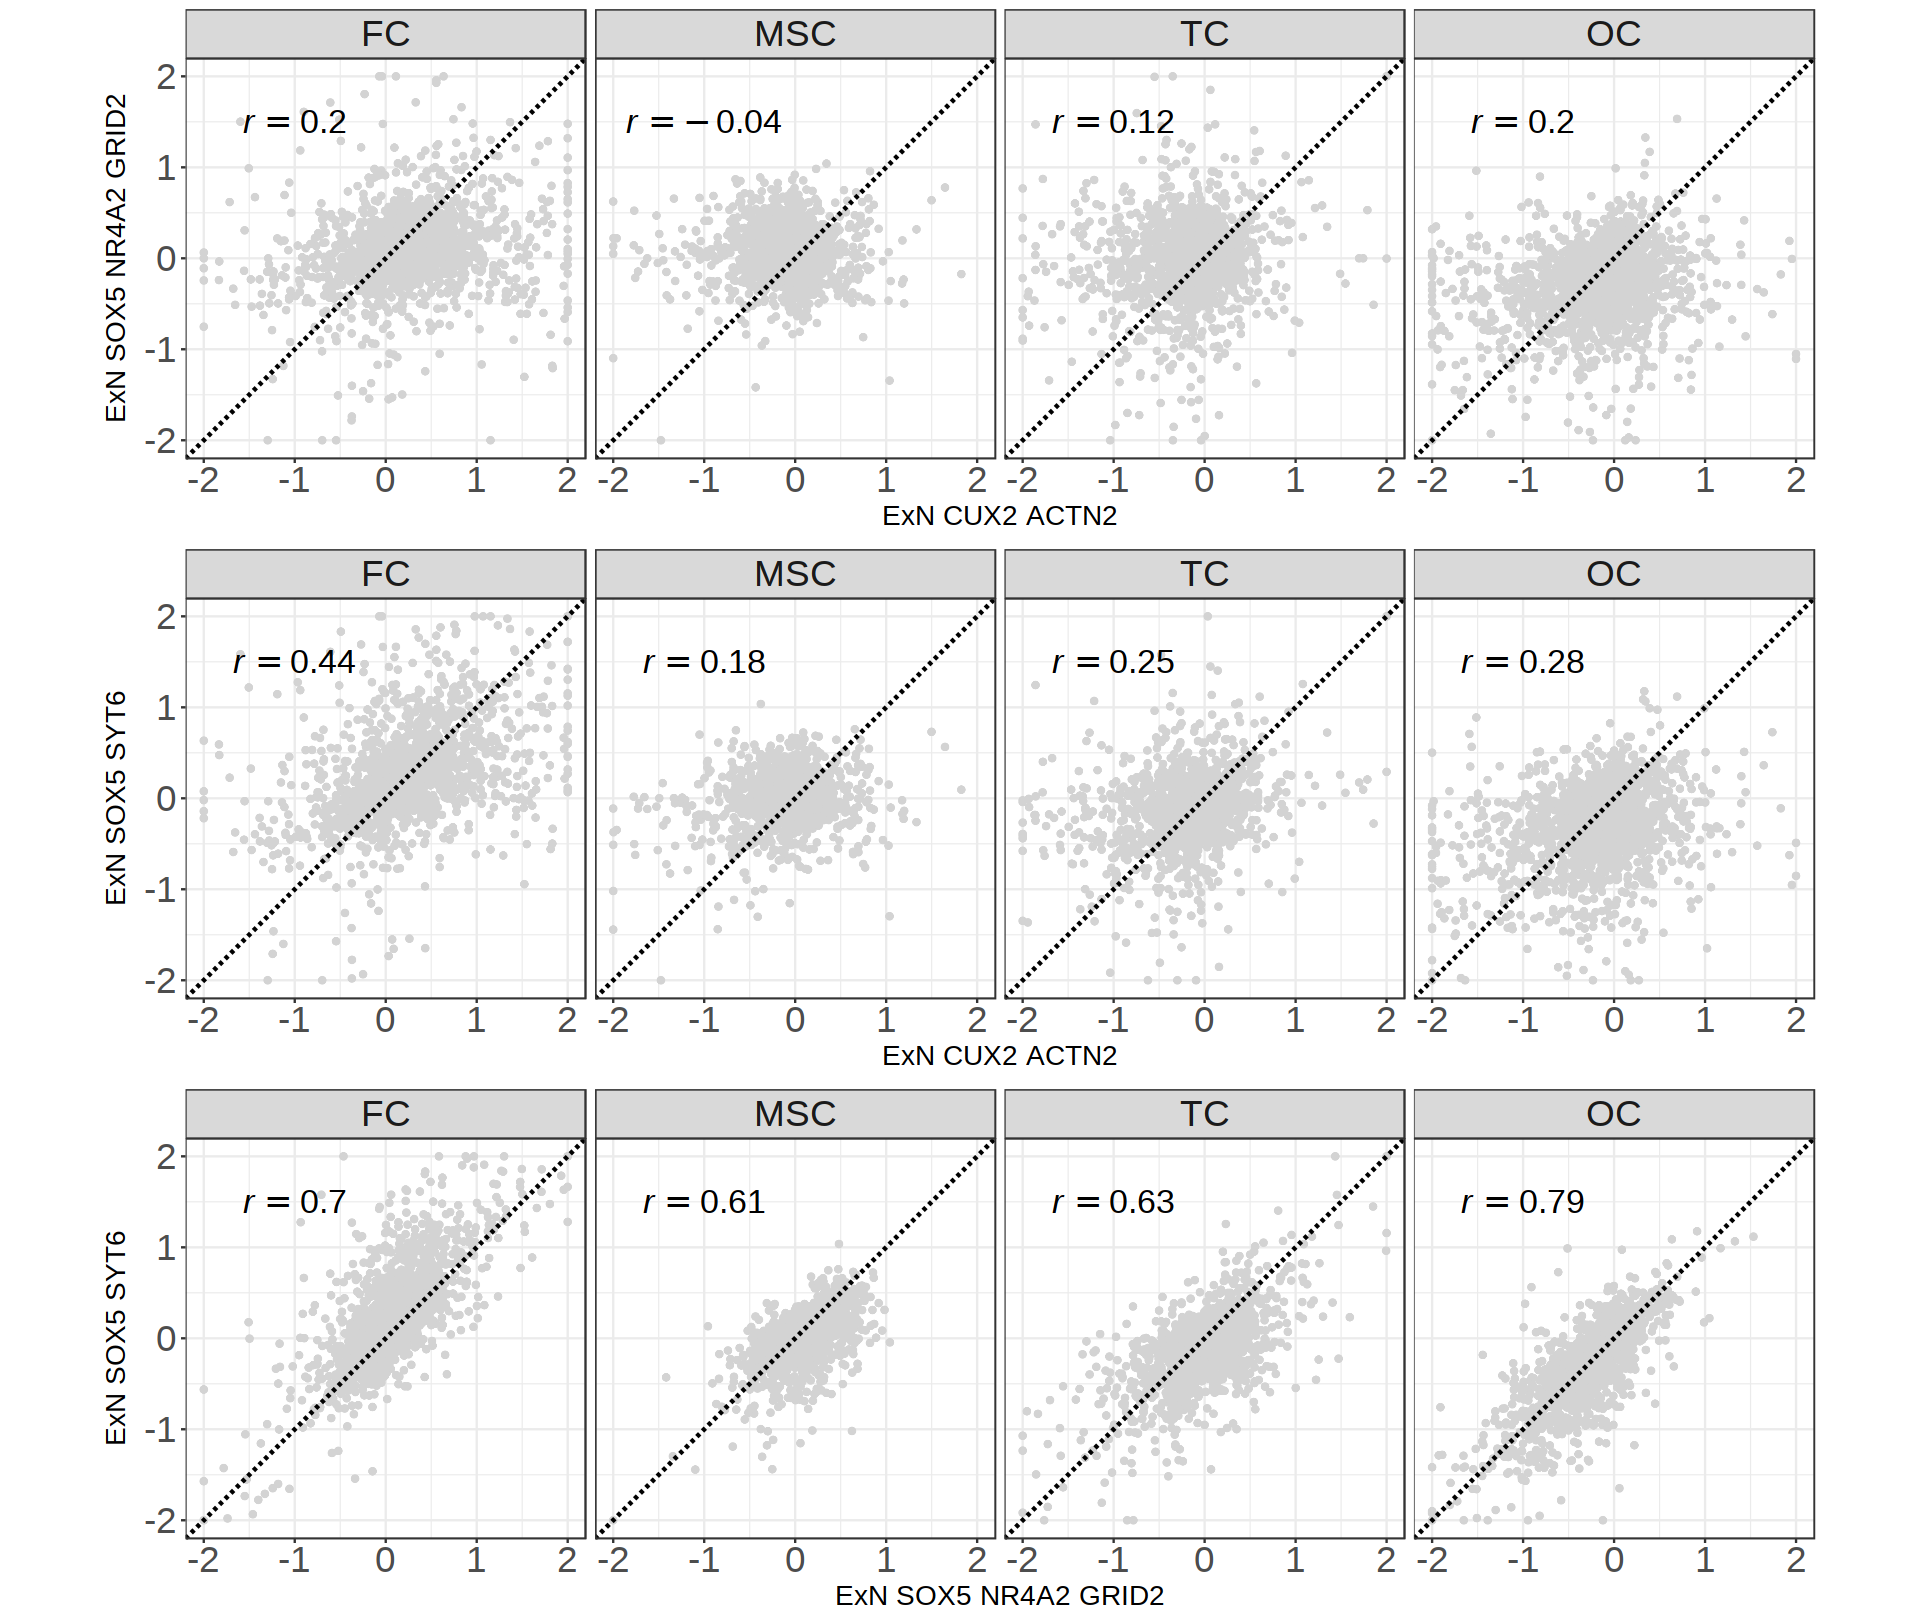

In [6]:
plist <- list()
for (ii in 1:length(all_pairs)){
    sel_pairs <- all_pairs[[ii]]

    ## Fold changes
    fc_list <- lapply(sel_pairs, function(gp) {
        subavg <- as.matrix(avgs[, paste0(gp, "|", reg_ord)])
        subfc <- lapply(reg_ord, function(reg) {
            bg_avg <- subavg[, paste0(gp, "|", setdiff(reg_ord, reg))]
            fc <- (subavg[, paste0(gp, "|", reg)] + ptval)/(rowMeans(bg_avg) + ptval)
            return(fc)
            }) %>%
            do.call(cbind, .)
        colnames(subfc) <- reg_ord
        return(subfc)
        }) %>%
        setNames(., sel_pairs)


    reg_ord <- c("FC", "MSC", "TC", "OC")
    pdata <- lapply(reg_ord, function(reg) {
        print(reg)
        data <- data.frame(gene = gene_use, 
                        xaxis = log2(fc_list[[sel_pairs[1]]][gene_use, reg]), 
                        yaxis = log2(fc_list[[sel_pairs[2]]][gene_use, reg]), 
                        region = reg,
                        stringsAsFactors = FALSE)
        return(data)
        }) %>%
            do.call(rbind, .) %>%
            mutate(region = factor(region, levels = reg_ord)) %>%
            mutate(xaxis = MinMax(xaxis, min = -2, max = 2)) %>%
            mutate(yaxis = MinMax(yaxis, min = -2, max = 2))
    print(sum(is.na(pdata)))


    ## Correlation fold changes
    cordata <- lapply(reg_ord, function(reg) {
        value <- cor(log2(fc_list[[sel_pairs[1]]][gene_use, reg]), 
                     log2(fc_list[[sel_pairs[2]]][gene_use, reg]), 
                     method = "p")
        data <- data.frame(xaxis = -1, 
                            yaxis = 1.5,
                            label = paste0("italic(r) == ", round(value, digits = 2)), 
                            region = reg,
                            stringsAsFactors = FALSE)
        return(data)
        }) %>%
            do.call(rbind, .) %>%
            mutate(region = factor(region, levels = reg_ord))
    print(sum(is.na(pdata)))

    plist[[ii]] <- ggplot(pdata, aes(x = xaxis, y = yaxis)) +
            ggrastr::rasterise(geom_point(size = 2, color = "lightgrey", shape = 16), dpi = 300) +
            geom_text(data = cordata, mapping = aes(label = label), size = 7, parse = TRUE) +
            theme_bw() +
            geom_abline(intercept = 0, slope = 1, linetype = "dashed", size = 1) +
            facet_grid(cols = vars(region)) +
            coord_fixed() + 
            labs(x = sel_pairs[1], y = sel_pairs[2]) +
            theme(legend.position = "none", 
                     axis.text = element_text(size = rel(2)), 
                     strip.text = element_text(size = rel(2)),
                     axis.title = element_text(size = rel(1.5)))
}

pp <- cowplot::plot_grid(plotlist = plist, nrow = 3, ncol = 1)
options(repr.plot.width=16, repr.plot.height=13.5, res = 300)
pp

In [7]:
pdf(paste0("./report/", "Correlation.DeepUpper.DEGs.all.pdf"), width = 4.5 * length(reg_ord), height = 4.5 * 3)
print(pp)
dev.off()

png 
  2

In [8]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server 7.9 (Maipo)

Matrix products: default
BLAS:   /gpfs/ycga/home/sm2726/packages/R_versions/R-3.6.1/lib64/R/lib/libRblas.so
LAPACK: /gpfs/ycga/home/sm2726/packages/R_versions/R-3.6.1/lib64/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggplot2_3.3.0 dplyr_1.0.7   Seurat_3.1.5 

loaded via a namespace (and not attached):
 [1] nlme_3.1-147        tsne_0.1-3          RcppAnnoy_0.0.16   
 [4] RColorBrewer_1.1-2  httr_1.4.1 